<a href="https://colab.research.google.com/github/rishi-jaizz/Deep-Learning/blob/main/GANs_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Synthetic Data Generation for Fashion Items with GANs**

####Import Libraries and Set Up Hyperparameters

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
LATENT_DIM = 100
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.0002
BETA1 = 0.5

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


####Prepare Dataset and DataLoader

In [ ]:
# Data transforms and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


####Define the Generator and Discriminator Networks

In [ ]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        output = self.model(img_flat)
        return output


####Initialize Networks and Optimizers


In [ ]:
# Weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.zeros_(m.bias.data)

# Initialize networks
generator = Generator(LATENT_DIM).to(device)
discriminator = Discriminator().to(device)

# Initialize weights
generator.apply(weights_init)
discriminator.apply(weights_init)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))


####Plotting Function

In [ ]:
# Function to plot real vs generated images
def plot_real_vs_generated(real_images, generated_images, epoch):
    plt.figure(figsize=(12, 6))

    # Plot real images
    plt.subplot(1, 2, 1)
    real_grid = torchvision.utils.make_grid(real_images[:25], nrow=5, normalize=True)
    plt.title(f'Real Images (Epoch {epoch})')
    plt.imshow(real_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')

    # Plot generated images
    plt.subplot(1, 2, 2)
    fake_grid = torchvision.utils.make_grid(generated_images[:25], nrow=5, normalize=True)
    plt.title(f'Generated Images (Epoch {epoch})')
    plt.imshow(fake_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'comparison_epoch_{epoch}.png')
    plt.close()


####Training Loop

In [ ]:
# Training Loop with Image Comparison
def train_gan():
    for epoch in range(EPOCHS):
        for i, (real_images, _) in enumerate(train_loader):
            batch_size = real_images.size(0)

            # Prepare labels
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Move real images to device
            real_images = real_images.to(device)

            # Train Generator
            optimizer_G.zero_grad()

            # Generate fake images
            z = torch.randn(batch_size, LATENT_DIM).to(device)
            generated_images = generator(z)

            # Generator loss
            g_loss = adversarial_loss(discriminator(generated_images), real_labels)
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()

            # Real images loss
            real_loss = adversarial_loss(discriminator(real_images), real_labels)

            # Fake images loss
            z = torch.randn(batch_size, LATENT_DIM).to(device)
            generated_images = generator(z)
            fake_loss = adversarial_loss(discriminator(generated_images.detach()), fake_labels)

            # Total discriminator loss
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

        # Compare real and generated images every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Get a batch of real images
            real_batch = next(iter(train_loader))[0]

            # Generate fake images
            z = torch.randn(BATCH_SIZE, LATENT_DIM).to(device)
            with torch.no_grad():
                fake_batch = generator(z).cpu()

            # Plot and save comparison
            plot_real_vs_generated(real_batch, fake_batch, epoch + 1)

        # Print progress
        print(f'Epoch [{epoch+1}/{EPOCHS}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')


####Train the GAN

In [ ]:
if __name__ == '__main__':
    train_gan()
    print("GAN training completed. Comparison images saved.")


Epoch [1/50], D Loss: 0.4609, G Loss: 1.3410
Epoch [2/50], D Loss: 0.6045, G Loss: 1.1763
Epoch [3/50], D Loss: 0.6125, G Loss: 1.0258
Epoch [4/50], D Loss: 0.6524, G Loss: 0.8604
Epoch [5/50], D Loss: 0.7182, G Loss: 0.9057
Epoch [6/50], D Loss: 0.6746, G Loss: 1.0875
Epoch [7/50], D Loss: 0.6302, G Loss: 0.8327
Epoch [8/50], D Loss: 0.6174, G Loss: 0.8509
Epoch [9/50], D Loss: 0.6671, G Loss: 0.8332
Epoch [10/50], D Loss: 0.6675, G Loss: 0.8666
Epoch [11/50], D Loss: 0.6498, G Loss: 0.7208
Epoch [12/50], D Loss: 0.6481, G Loss: 0.8132
Epoch [13/50], D Loss: 0.6413, G Loss: 0.8573
Epoch [14/50], D Loss: 0.6878, G Loss: 0.8853
Epoch [15/50], D Loss: 0.6390, G Loss: 0.7965
Epoch [16/50], D Loss: 0.6847, G Loss: 0.7851
Epoch [17/50], D Loss: 0.6761, G Loss: 0.7441
Epoch [18/50], D Loss: 0.6733, G Loss: 0.8402
Epoch [19/50], D Loss: 0.6945, G Loss: 0.7538
Epoch [20/50], D Loss: 0.6809, G Loss: 0.8463
Epoch [21/50], D Loss: 0.6667, G Loss: 0.7927
Epoch [22/50], D Loss: 0.6560, G Loss: 0.74

####Display Saved Images

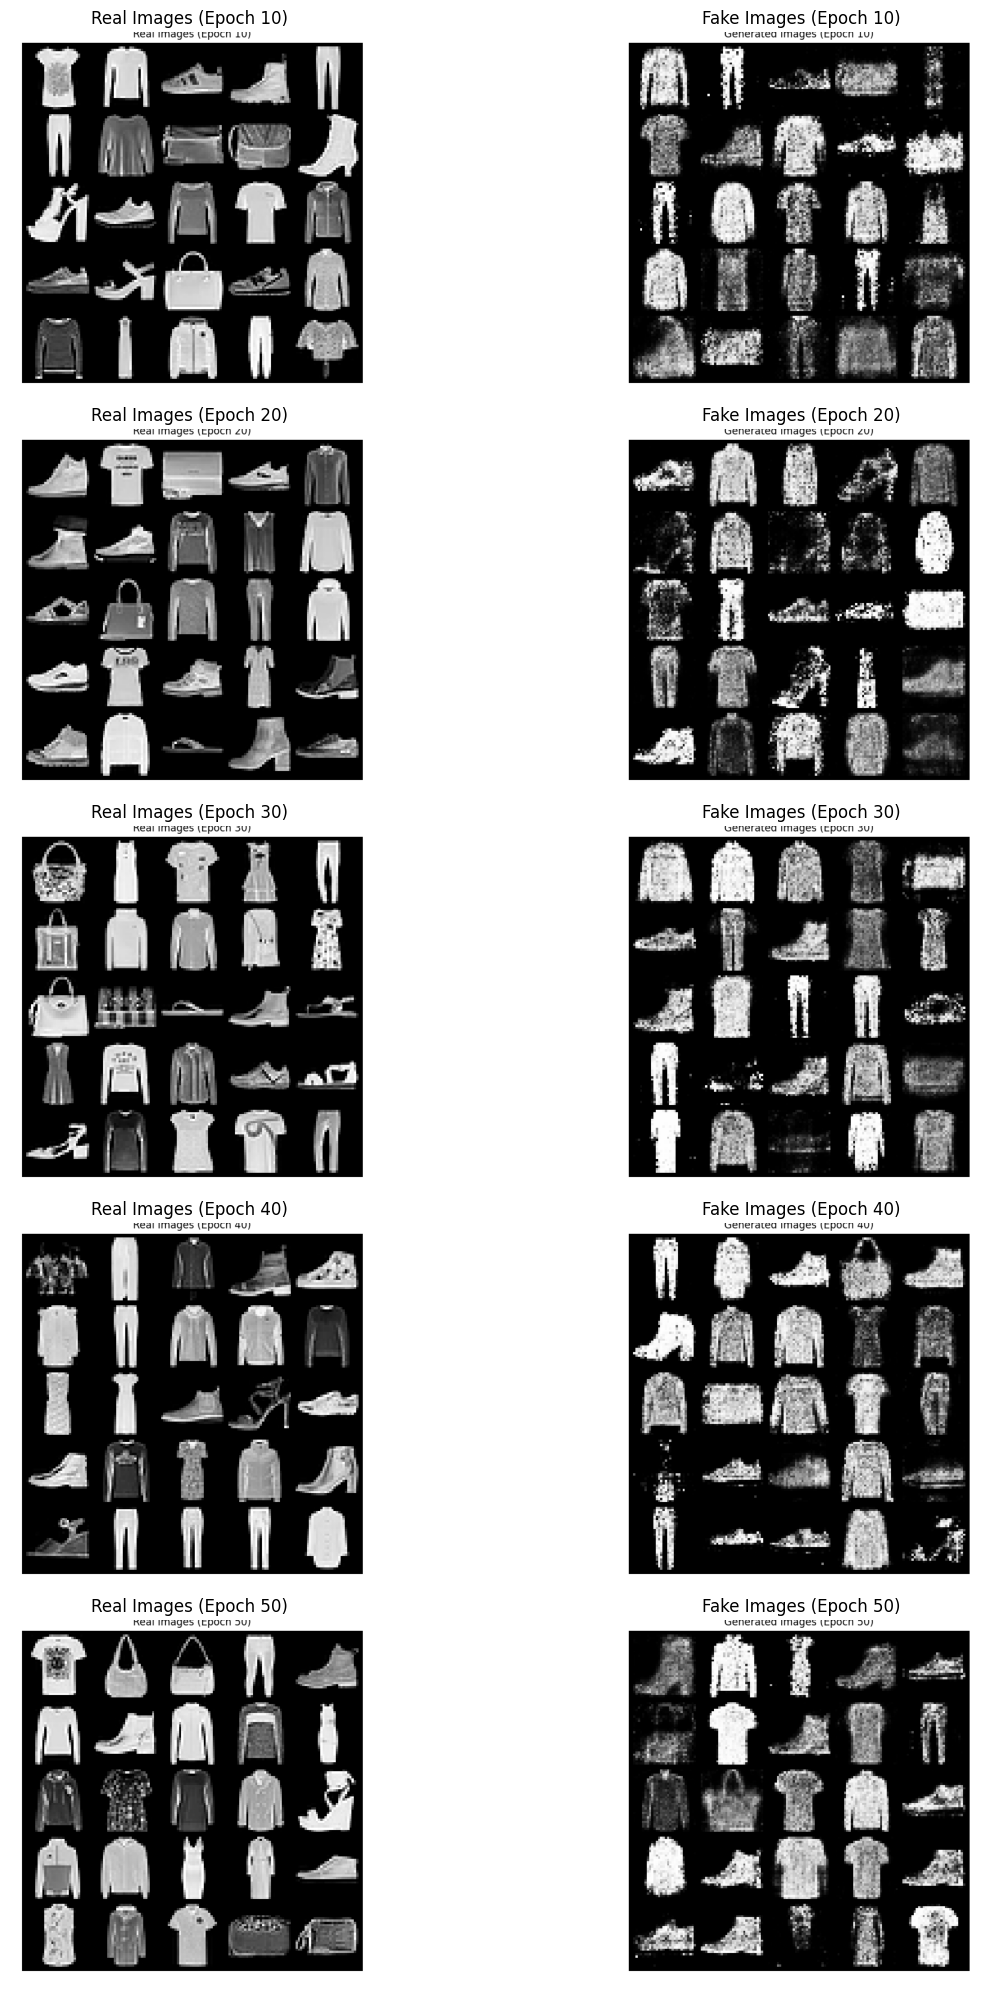

In [ ]:
def display_gan_images(epochs_to_show=[10, 20, 30, 40, 50]):
    """
    Display saved GAN comparison images with real and generated images separately.

    Args:
    epochs_to_show (list): List of epochs to display images for
    """
    # Create a grid of subplots
    fig, axes = plt.subplots(len(epochs_to_show), 2, figsize=(15, 4*len(epochs_to_show)))

    # Iterate through specified epochs
    for i, epoch in enumerate(epochs_to_show):
        # Construct filename
        filename = f'comparison_epoch_{epoch}.png'

        # Check if file exists
        if os.path.exists(filename):
            # Read and display the image
            img = mpimg.imread(filename)

            # Split the image into real and generated halves
            height, width, _ = img.shape
            real_half = img[:, :width//2]
            generated_half = img[:, width//2:]

            # Display real images
            axes[i, 0].imshow(real_half)
            axes[i, 0].set_title(f'Real Images (Epoch {epoch})')
            axes[i, 0].axis('off')

            # Display generated images
            axes[i, 1].imshow(generated_half)
            axes[i, 1].set_title(f'Fake Images (Epoch {epoch})')
            axes[i, 1].axis('off')
        else:
            print(f"Image for epoch {epoch} not found.")

    plt.tight_layout()
    plt.show()

# Call the function to display images
display_gan_images()